In [1]:
import scanpy as sc
data_dir = '../../dataset/Xenium_breast_cancer_sample1_replicate1.h5ad'
adata = sc.read_h5ad(data_dir)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [2]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
from torch.optim import AdamW
import lightning.pytorch as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPBarlowTwins
from self_supervision.estimator.cellnet import EstimatorAutoEncoder

# 设置你的 .ckpt 文件路径
ckpt_path = "../../sc_pretrained/Pretrained Models/BarlowTwins.ckpt"

# 模型参数
units_encoder = [512, 512, 256, 256, 64]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 如果没有实际数据路径，可以设置为None

# 加载预训练模型
estim.model = MLPBarlowTwins(
        gene_dim=19331,  # 根据你的数据调整
        batch_size=128,  # 根据你的需要调整
        units_encoder=units_encoder,
        CHECKPOINT_PATH=ckpt_path
    )


estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
estim.model

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


MLPBarlowTwins(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (inner_model): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=256, out_features=25

In [3]:
# 加载 checkpoint
checkpoint = torch.load(ckpt_path)
estim.model.inner_model.load_state_dict({k.replace('backbone.', ''): v for k, v in checkpoint.items() if 'backbone' in k})

# 5. 添加分类层 (FC 层)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)

In [4]:
# 6. 冻结 encoder 的大部分参数，解冻所有层
for param in estim.model.inner_model.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻最后两层
for param in list(estim.model.inner_model.parameters())[-5:]:
    param.requires_grad = True

In [5]:
# 7. 定义损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
estim.model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)

In [6]:
import pandas as pd
import numpy as np

var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
all_genes = var_df['feature_name'].tolist()

new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

adata.var['gene_name']=adata.var.index
existing_genes = adata.var['gene_name']

In [7]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes

匹配的基因数量: 305
匹配的基因列表: {'lum', 'sox17', 'cavin2', 'lep', 'mmp1', 'tacstd2', 'dnaaf1', 'ramp2', 'slc5a6', 'clecl1', 'klrf1', 'aqp1', 'pigr', 'adgre5', 'serpinb9', 'rorc', 'aldh1a3', 'egfr', 'pecam1', 'tceal7', 'c5orf46', 'hoxd9', 'dsp', 'tyrobp', 'spib', 'ccl5', 'map3k8', 'slc25a37', 'sqle', 'pgr', 'usp53', 'clic6', 'il2ra', 'ucp1', 'ccl20', 'acta2', 'medag', 'eif4ebp1', 'gzma', 'cenpf', 'mlph', 'adipoq', 'lpl', 'tomm7', 'ptn', 'klrb1', 'cdh1', 'ccdc80', 'vwf', 'gnly', 'mylk', 'muc6', 'hoxd8', 'pparg', 'ccdc6', 'nostrin', 'cd8a', 'smap2', 'clca2', 'rhoh', 'oxtr', 'elf3', 'cxcl12', 'c2orf42', 'pde4a', 'ccpg1', 'snai1', 'ncam1', 'cyp1a1', 'cldn5', 'ociad2', 'gjb2', 'il7r', 'gpr183', 'cxcl5', 'akr1c1', 'cav1', 'pdcd1', 'cd79b', 'fcer1a', 'lgalsl', 'glipr1', 'krt8', 'cd4', 'ceacam6', 'apoc1', 'thap2', 'myo5b', 'sdc4', 'trappc3', 'gzmk', 'apobec3b', 'tubb2b', 'dnttip1', 'znf562', 'jup', 'cldn4', 'serhl2', 'pim1', 'epcam', 'klrd1', 'cd69', 'kit', 'ndufa4l2', 'tac1', 'timp4', 'btnl9', 'cxcl16',

{'fam49a', 'kars', 'lars', 'nars', 'polr2j3', 'qars', 'trac', 'wars'}

In [8]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

Gene fam49a not found in all_genes list
Gene kars not found in all_genes list


Gene lars not found in all_genes list
Gene nars not found in all_genes list


Gene polr2j3 not found in all_genes list
Gene qars not found in all_genes list


Gene trac not found in all_genes list
Gene wars not found in all_genes list


In [9]:
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
# 5. 数据集划分（70% 训练，15% 验证，15% 测试）
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


In [10]:
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)

In [11]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.inner_model(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.inner_model(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [12]:
torch.cuda.empty_cache()

In [13]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")

Epoch 1, Train Loss: 0.5759692994760013, Validation Loss: 0.4227222274553957


Validation loss improved to 0.4227222274553957, resetting patience.


Epoch 2, Train Loss: 0.4149970187113695, Validation Loss: 0.39441895220182877
Validation loss improved to 0.39441895220182877, resetting patience.


Epoch 3, Train Loss: 0.38734839228438395, Validation Loss: 0.3530434879100867
Validation loss improved to 0.3530434879100867, resetting patience.


Epoch 4, Train Loss: 0.37099776907229476, Validation Loss: 0.38394243758039426
No improvement in validation loss. Patience counter: 1/20


Epoch 5, Train Loss: 0.3573476911272878, Validation Loss: 0.3437518762604234
Validation loss improved to 0.3437518762604234, resetting patience.


Epoch 6, Train Loss: 0.34855335145734234, Validation Loss: 0.32352081001712585
Validation loss improved to 0.32352081001712585, resetting patience.


Epoch 7, Train Loss: 0.34254150954531687, Validation Loss: 0.3778070626676385
No improvement in validation loss. Patience counter: 1/20


Epoch 8, Train Loss: 0.3353996982144634, Validation Loss: 0.357929033525099
No improvement in validation loss. Patience counter: 2/20


Epoch 9, Train Loss: 0.3304104938259052, Validation Loss: 0.3172870797251687
Validation loss improved to 0.3172870797251687, resetting patience.


Epoch 10, Train Loss: 0.3283351430576092, Validation Loss: 0.39824561192299507
No improvement in validation loss. Patience counter: 1/20


Epoch 11, Train Loss: 0.3236961121263068, Validation Loss: 0.3266176885457208
No improvement in validation loss. Patience counter: 2/20


Epoch 12, Train Loss: 0.32201991322772955, Validation Loss: 0.31863011631566257
No improvement in validation loss. Patience counter: 3/20


Epoch 13, Train Loss: 0.31721932278674153, Validation Loss: 0.3231147285645383
No improvement in validation loss. Patience counter: 4/20


Epoch 14, Train Loss: 0.3165689976256917, Validation Loss: 0.32755117897454855
No improvement in validation loss. Patience counter: 5/20


Epoch 15, Train Loss: 0.31255849265779545, Validation Loss: 0.30659657504957943
Validation loss improved to 0.30659657504957943, resetting patience.


Epoch 16, Train Loss: 0.3124338966796341, Validation Loss: 0.3039498498597121
Validation loss improved to 0.3039498498597121, resetting patience.


Epoch 17, Train Loss: 0.31011877369646934, Validation Loss: 0.29233270671767025
Validation loss improved to 0.29233270671767025, resetting patience.


Epoch 18, Train Loss: 0.3071248661199167, Validation Loss: 0.30478509247000446
No improvement in validation loss. Patience counter: 1/20


Epoch 19, Train Loss: 0.3031229107013715, Validation Loss: 0.3050491394579108
No improvement in validation loss. Patience counter: 2/20


Epoch 20, Train Loss: 0.30229267528309023, Validation Loss: 0.3019115724388113
No improvement in validation loss. Patience counter: 3/20


Epoch 21, Train Loss: 0.30290907597035366, Validation Loss: 0.35094245383279576
No improvement in validation loss. Patience counter: 4/20


Epoch 22, Train Loss: 0.29949775151502595, Validation Loss: 0.3151655522397327
No improvement in validation loss. Patience counter: 5/20


Epoch 23, Train Loss: 0.2977463645710405, Validation Loss: 0.32315665922189124
No improvement in validation loss. Patience counter: 6/20


Epoch 24, Train Loss: 0.2993490778737598, Validation Loss: 0.309044157414872
No improvement in validation loss. Patience counter: 7/20


Epoch 25, Train Loss: 0.29715913780893893, Validation Loss: 0.2918733013462899
Validation loss improved to 0.2918733013462899, resetting patience.


Epoch 26, Train Loss: 0.2961721504208569, Validation Loss: 0.3019777834415436
No improvement in validation loss. Patience counter: 1/20


Epoch 27, Train Loss: 0.29808862448907364, Validation Loss: 0.29710202773815486
No improvement in validation loss. Patience counter: 2/20


Epoch 28, Train Loss: 0.294718096539995, Validation Loss: 0.29504718612595865
No improvement in validation loss. Patience counter: 3/20


Epoch 29, Train Loss: 0.29266659251550187, Validation Loss: 0.31600695462698863
No improvement in validation loss. Patience counter: 4/20


Epoch 30, Train Loss: 0.29222832691565576, Validation Loss: 0.30677242266950266
No improvement in validation loss. Patience counter: 5/20


Epoch 31, Train Loss: 0.29300386573883963, Validation Loss: 0.3103094626653013
No improvement in validation loss. Patience counter: 6/20


Epoch 32, Train Loss: 0.29204022428244025, Validation Loss: 0.29012747804828104
Validation loss improved to 0.29012747804828104, resetting patience.


Epoch 33, Train Loss: 0.2897015207798133, Validation Loss: 0.2907006096870161
No improvement in validation loss. Patience counter: 1/20


Epoch 34, Train Loss: 0.2935126260377483, Validation Loss: 0.3025694763297357
No improvement in validation loss. Patience counter: 2/20


Epoch 35, Train Loss: 0.2910657207723017, Validation Loss: 0.2842584221344914
Validation loss improved to 0.2842584221344914, resetting patience.


Epoch 36, Train Loss: 0.2919097605094411, Validation Loss: 0.3246681407320923
No improvement in validation loss. Patience counter: 1/20


Epoch 37, Train Loss: 0.28841903870661534, Validation Loss: 0.2966428370342642
No improvement in validation loss. Patience counter: 2/20


Epoch 38, Train Loss: 0.28912392377950785, Validation Loss: 0.2873710672262356
No improvement in validation loss. Patience counter: 3/20


Epoch 39, Train Loss: 0.2906608518480865, Validation Loss: 0.3180784117903201
No improvement in validation loss. Patience counter: 4/20


Epoch 40, Train Loss: 0.2886188200681038, Validation Loss: 0.28451721877010944
No improvement in validation loss. Patience counter: 5/20


Epoch 41, Train Loss: 0.2872213622096577, Validation Loss: 0.30819246142648804
No improvement in validation loss. Patience counter: 6/20


Epoch 42, Train Loss: 0.28853453010775165, Validation Loss: 0.30876793375777717
No improvement in validation loss. Patience counter: 7/20


Epoch 43, Train Loss: 0.2868565421040152, Validation Loss: 0.3010040670633316
No improvement in validation loss. Patience counter: 8/20


Epoch 44, Train Loss: 0.28797749066339856, Validation Loss: 0.30283998989211725
No improvement in validation loss. Patience counter: 9/20


Epoch 45, Train Loss: 0.2885036127954267, Validation Loss: 0.2883941827691751
No improvement in validation loss. Patience counter: 10/20


Epoch 46, Train Loss: 0.28825552173949015, Validation Loss: 0.29832731974003884
No improvement in validation loss. Patience counter: 11/20


Epoch 47, Train Loss: 0.286697487831765, Validation Loss: 0.297553877691327
No improvement in validation loss. Patience counter: 12/20


Epoch 48, Train Loss: 0.28692325202987606, Validation Loss: 0.28573194849612144
No improvement in validation loss. Patience counter: 13/20


Epoch 49, Train Loss: 0.28678397512903403, Validation Loss: 0.2926554744164956
No improvement in validation loss. Patience counter: 14/20


Epoch 50, Train Loss: 0.28413585728452356, Validation Loss: 0.29929944282860926
No improvement in validation loss. Patience counter: 15/20


Epoch 51, Train Loss: 0.28648241916123557, Validation Loss: 0.29018403332548093
No improvement in validation loss. Patience counter: 16/20


Epoch 52, Train Loss: 0.2851407381103319, Validation Loss: 0.27627427172539804
Validation loss improved to 0.27627427172539804, resetting patience.


Epoch 53, Train Loss: 0.2833998483283068, Validation Loss: 0.2921973817088277
No improvement in validation loss. Patience counter: 1/20


Epoch 54, Train Loss: 0.2859838939229258, Validation Loss: 0.3113569087788538
No improvement in validation loss. Patience counter: 2/20


Epoch 55, Train Loss: 0.28495758510557917, Validation Loss: 0.28439043696761734
No improvement in validation loss. Patience counter: 3/20


Epoch 56, Train Loss: 0.28370310158381534, Validation Loss: 0.28775481183819357
No improvement in validation loss. Patience counter: 4/20


Epoch 57, Train Loss: 0.2870885302639345, Validation Loss: 0.28444907553304877
No improvement in validation loss. Patience counter: 5/20


Epoch 58, Train Loss: 0.28413868613524895, Validation Loss: 0.2903218977342402
No improvement in validation loss. Patience counter: 6/20


Epoch 59, Train Loss: 0.28414350353619633, Validation Loss: 0.3006412446650152
No improvement in validation loss. Patience counter: 7/20


Epoch 60, Train Loss: 0.28478013005002134, Validation Loss: 0.2928030472721545
No improvement in validation loss. Patience counter: 8/20


Epoch 61, Train Loss: 0.28334037794007194, Validation Loss: 0.32487464556234136
No improvement in validation loss. Patience counter: 9/20


Epoch 62, Train Loss: 0.28275495154016156, Validation Loss: 0.3062402399512112
No improvement in validation loss. Patience counter: 10/20


Epoch 63, Train Loss: 0.2829136524130316, Validation Loss: 0.33582793932578286
No improvement in validation loss. Patience counter: 11/20


Epoch 64, Train Loss: 0.28082014108989756, Validation Loss: 0.28893616311441217
No improvement in validation loss. Patience counter: 12/20


Epoch 65, Train Loss: 0.28454497141645885, Validation Loss: 0.30819897678902913
No improvement in validation loss. Patience counter: 13/20


Epoch 66, Train Loss: 0.28192675732124867, Validation Loss: 0.3031960746207213
No improvement in validation loss. Patience counter: 14/20


Epoch 67, Train Loss: 0.28479386418083913, Validation Loss: 0.28452134223153747
No improvement in validation loss. Patience counter: 15/20


Epoch 68, Train Loss: 0.28266832380188317, Validation Loss: 0.3138497133696745
No improvement in validation loss. Patience counter: 16/20


Epoch 69, Train Loss: 0.28258366994803247, Validation Loss: 0.28970179211367203
No improvement in validation loss. Patience counter: 17/20


Epoch 70, Train Loss: 0.28263638839774924, Validation Loss: 0.31663730006835183
No improvement in validation loss. Patience counter: 18/20


Epoch 71, Train Loss: 0.2815662748738312, Validation Loss: 0.29559480758185314
No improvement in validation loss. Patience counter: 19/20


Epoch 72, Train Loss: 0.2836996332005738, Validation Loss: 0.28608004665616804
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 72.
Loaded best model weights based on validation loss.


In [14]:
import os

# 定义保存路径
save_dir = './xenium_best_model_ckpt'
save_path = os.path.join(save_dir, f'BT_FT_Xenium_breast_cancer_sample1_replicate1_best_model_{random_seed}.ckpt')

# 如果目录不存在，则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(best_model_weights, save_path)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


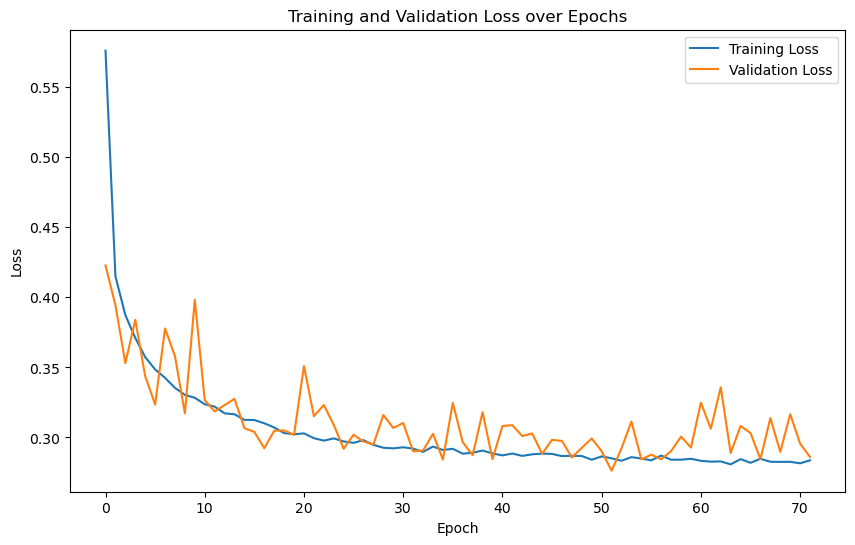

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig(f'../loss_curve_fig/Xenium_breast_cancer_barlow_twins_finetune_full_loss_curve{random_seed}.png', dpi=400)  # 保存图像为png格式，300 dpi
plt.savefig(f'../loss_curve_fig/Xenium_breast_cancer_barlow_twins_finetune_full_loss_curve{random_seed}.eps', format='eps', dpi=400)  # 保存图像为png格式，300 dpi

plt.show()


In [16]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.inner_model(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.inner_model(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [17]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.8887034608813128
Weighted F1 Score: 0.886804376550463
Macro F1 Score: 0.802801180501716
Random Guess Accuracy: 0.1320247177116093
                         precision    recall  f1-score   support

                B_Cells       0.90      0.94      0.92       772
           CD4+_T_Cells       0.77      0.86      0.81      1286
           CD8+_T_Cells       0.80      0.78      0.79      1026
                 DCIS_1       0.88      0.94      0.91      1937
                 DCIS_2       0.86      0.80      0.83      1746
            Endothelial       0.93      0.95      0.94      1348
              IRF7+_DCs       0.96      0.88      0.92        74
         Invasive_Tumor       0.93      0.94      0.93      5230
             LAMP3+_DCs       0.82      0.82      0.82        49
          Macrophages_1       0.88      0.90      0.89      1692
          Macrophages_2       0.75      0.78      0.77       223
             Mast_Cells       0.80      0.71      0.75      

In [18]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.inner_model(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'SSL_BT_FT_{random_seed}'] = SSL_embeddings
new_adata.uns[f'BT_FT_y_test_{random_seed}'] = y_test
new_adata.uns[f'BT_FT_predictions_{random_seed}'] = predictions
new_adata.uns[f'BT_FT_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'BT_FT_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'BT_FT_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

In [19]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "Xenium_breast_cancer_sample1_replicate1_barlow_twins_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicor_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['xenium_breast_cancer_sample1_replicate1'],
    'method': [re.search(r'replicate1_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micor_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micor_f1
0.576	0.423	52	0.276	0.803	0.887	0.889
